In [1]:
import os, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tifffile as tiff
import scipy.ndimage
from cellpose import models
from readimc import MCDFile, TXTFile

In [9]:
work_dir = os.getcwd()
data_dir = "/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250425_RCA_imager_hyb_opti/20240425_RCA_in_vitro_hyb_opti_s3"

# list out all the files in the directory
mcd_list = os.listdir(data_dir)
mcd_list = [f for f in mcd_list if f.endswith('.mcd')]

df_list = os.listdir(data_dir)
df_list = [f for f in df_list if f.endswith('.xlsx')]

print(mcd_list)
print(df_list)


['20240425_RCA_in_vitro_hyb_opti_s3.mcd']
['20240425_RCA_in_vitro_hyb_opti_s3_df.xlsx']


In [10]:
tif_dir = os.path.join(data_dir, 'tif')
if not os.path.exists(tif_dir):
    os.makedirs(tif_dir)

In [11]:
df = pd.read_excel(os.path.join(data_dir, df_list[0]))
# set the data type of the columns
df = df.astype({'file_name': 'str', 'image_decay': 'str', 'resolution': 'float', 'power': 'int', 'shot': 'int', 'rep': 'int', 'id': 'str', 'cond': 'str'})

In [12]:
df.head(70)

,file_name,image_decay,resolution,power,shot,rep,id,cond
0,20240425_RCA_in_vitro_hyb_opti_s3_ROI_001_1,image,1.0,0,1,1,1,imager_washed
1,20240425_RCA_in_vitro_hyb_opti_s3_ROI_002_2,image,1.0,0,1,1,2,imager_dried
2,20240425_RCA_in_vitro_hyb_opti_s3_ROI_003_3,image,1.0,0,1,1,3,37d_PBS_Dy161
3,20240425_RCA_in_vitro_hyb_opti_s3_ROI_004_4,image,1.0,0,1,1,4,37d_PBS_Tm169
4,20240425_RCA_in_vitro_hyb_opti_s3_ROI_005_5,image,1.0,0,1,1,5,37d_SSC_Dy161
5,20240425_RCA_in_vitro_hyb_opti_s3_ROI_006_6,image,1.0,0,1,1,6,37d_SSC_Tm169


## Read in files

In [13]:
def read_imc_dict(file_big, id):
    #return a dictionary with three images: slide, panorama, imc
    with MCDFile(file_big) as f:
        slide = f.slides[0] # first slide
        panorama = slide.panoramas[0] # first panorama of first slide
        acquisition = slide.acquisitions[id-1]
        
        channel_labels = acquisition.channel_labels
        
        img_slide = f.read_slide(slide)
        img_panorama = f.read_panorama(panorama)
        img_imc = f.read_acquisition(acquisition)

        # put the image into a dictionary
        img_dict = {}
        img_dict['slide'] = img_slide
        img_dict['panorama'] = img_panorama
        img_dict['description'] = acquisition.description
        img_dict['imc'] = img_imc
    return img_dict, channel_labels

def convert_imc_to_tif(file_big, id, output_dir):
    with MCDFile(file_big) as f:
        slide = f.slides[0] # first slide
        acquisition = slide.acquisitions[id-1] # nineth acquisition of first slide
        
        channel_labels = acquisition.channel_labels
        img_imc = f.read_acquisition(acquisition)
        # save the image as tif [channel, x, y]
        file_name = os.path.join(tif_dir, acquisition.description + ".tif")
        tiff.imwrite(file_name, img_imc)
    return

In [14]:
file_big =  mcd_list[0]
file_big = os.path.join(data_dir, file_big)
file_big

'/mnt/central_nas/users/ychian/Exp/202503_IMC_inten_encoding/20250425_RCA_imager_hyb_opti/20240425_RCA_in_vitro_hyb_opti_s3/20240425_RCA_in_vitro_hyb_opti_s3.mcd'

### Convert all image mcds to tiffs (standalone block)

In [15]:
for id in df['id'].unique():
    # convert the imc to tif
    id = int(id)
    print("Converting id: ", id)
    convert_imc_to_tif(file_big, id, tif_dir)

Converting id:  1
Converting id:  2
Converting id:  3
Converting id:  4
Converting id:  5
Converting id:  6


## Generate colormap

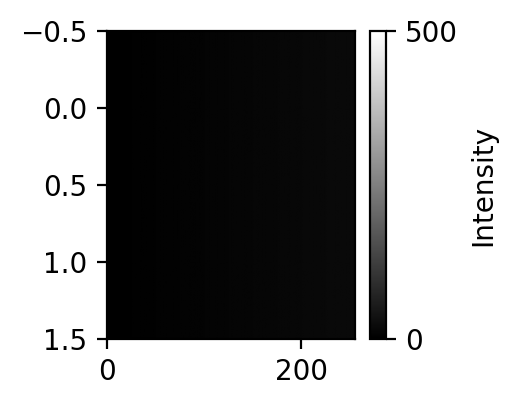

In [25]:
# generage grayscale colormap 0-20

plt.figure(figsize=(2, 2), dpi=200)
# plot a gradient from 0 to 20
gradient = np.linspace(0, 20, 256)
gradient = np.vstack((gradient, gradient))
plt.imshow(gradient, aspect='auto', cmap='gray')
plt.clim(0, 500)
# show colorbar, set ticks to 0, 20
plt.colorbar(ticks=[0, 500], label='Intensity')
plt.show()